In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# reza function

In [ ]:
from __future__ import division
import numpy as np
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes

# Functions
def hu_to_grayscale(volume):
    volume = np.clip(volume, -512, 512)
    mxval  = np.max(volume)
    mnval  = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
    im_volume = im_volume
    return im_volume *255

def get_mask_alung(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((15,15))).astype(vol_im.dtype)

    return around_lung

def get_mask(segmentation):
    # initialize output to zeros
    shp    = segmentation.shape
    lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)

    # Get mask for kidney and tumor
    lung[np.equal(segmentation,255)] = 255

    return lung

def get_FOV(around_lung, lung):
    FOV = np.where((around_lung + lung) >0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((5,5))).astype(FOV.dtype)
    return FOV

def return_axials(vol, seg):

    # Prepare segmentation and volume
    vol = vol.get_fdata() # Changed from get_data() to get_fdata()
    seg = seg.get_fdata() # Changed from get_data() to get_fdata()
    seg = seg.astype(np.int32)

    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol)
    lung    = get_mask(seg)
    around_lung = get_mask_alung(vol_ims)
    FOV = get_FOV(around_lung, lung)
    around_lung = np.where((FOV - lung) >0, 1, 0)

    return vol_ims, lung, around_lung, FOV




#data preparation


<ipython-input-2-8a6019767ef5>:3: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes
<ipython-input-2-8a6019767ef5>:3: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes


# Prepare Data

In [ ]:
from __future__ import division
import nibabel as nib
import numpy as np
import nibabel as nib
import glob
import os
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes # Added this line


# Define Train data and mask
Data_train   = []
Mask_train   = []
Maska_train  = []
FOV_train    = []

idx_count =1
Tr_add = '/content/drive/MyDrive/BDCU/lungs/3d_images'

Tr_list = glob.glob(Tr_add+'/*.gz')

for idx in range(len(Tr_list)):
    b = Tr_list[idx]
    a = b[len(Tr_add)+1:len(Tr_add)+4]
    if a=='IMG':
       print(idx_count)
       a = b[len(Tr_add)+5:len(b)]
       add = (Tr_add+'/MASK_' + a)
       vol = nib.load(Tr_list[idx])
       seg = nib.load(add)
       # Get the axials images and corresponding masks
       vol_ims, lung, around_lung, FOV = return_axials(vol, seg)
       # Changed line below to use get_fdata() instead of get_data()
       segmentation  = seg.get_fdata()
       # Insert samples to the Train data, which has the segmentation label
       for idx in range(vol.shape[0]):
           if ~( np.sum(np.sum(np.sum(segmentation[idx, :, :]))) == 0):
               Data_train.append(vol_ims [idx, :, :])
               Mask_train.append(lung[idx, :, :])
               Maska_train.append(around_lung[idx, :, :])
               FOV_train.append(FOV[idx, :, :])
       idx_count += 1

Data_train  = np.array(Data_train)
Mask_train  = np.array(Mask_train)
Maska_train = np.array(Maska_train)
FOV_train   = np.array(FOV_train)

# We use 70% of the data for training and 30% for test
alpha = np.int16(np.floor(Data_train.shape[0]* 0.7))
en_d  = Data_train.shape[0]

Train_img      = Data_train[0:alpha,:,:]
Test_img       = Data_train[alpha:en_d,:,:]

Train_mask     = Mask_train[0:alpha,:,:]
Test_mask      = Mask_train[alpha:en_d,:,:]

Train_maska     = Maska_train[0:alpha,:,:]
Test_maska      = Maska_train[alpha:en_d,:,:]

FOV_tr     = FOV_train[0:alpha,:,:]
FOV_te      = FOV_train[alpha:en_d,:,:]

folder = './processed_data/'
if not os.path.exists(folder):
    os.makedirs(folder)

np.save(folder+'data_train' , Train_img)
np.save(folder+'data_test'  , Test_img)
np.save(folder+'mask_train' , Train_mask)
np.save(folder+'mask_test'  , Test_mask)

np.save(folder+'Train_maska' , Train_maska)
np.save(folder+'Test_maska'  , Test_maska)
np.save(folder+'FOV_tr'      , FOV_tr)
np.save(folder+'FOV_te'      , FOV_te)

<ipython-input-3-798c490d749d>:7: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes # Added this line
<ipython-input-3-798c490d749d>:7: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes # Added this line


1
2
3
4


In [ ]:
 !ls

drive  processed_data  sample_data


# Model

In [ ]:
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import necessary libraries
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.utils import plot_model as plot
from keras.layers import *
import numpy as np

# --- Paste the content of ipython-input-22-ea20c6cfe762.py here ---
def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9) # This line was missing
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])  #Replaced in next line
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


# Training

In [ ]:
# ipython-input-23-ea20c6cfe762.py
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import necessary libraries
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.utils import plot_model as plot
from keras.layers import *
import numpy as np

!pip install scikit-image # installing scikit-image for resize
from skimage.transform import resize # import resize for preprocessing

# --- Paste the content of ipython-input-22-ea20c6cfe762.py here ---
def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9) # This line was missing
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])  #Replaced in next line
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model # Added return statement here. it was missing previously

# --- End of pasted content ---

# Continue with the rest of the code. Indented this block to be in the global scope.
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle

####################################  Load Data #####################################
folder = './processed_data/'
tr_data    = np.load(folder+'data_train.npy')
tr_mask    = np.load(folder+'Train_maska.npy')

# Resize training data and mask
tr_data = resize(tr_data, (tr_data.shape[0], 256, 256, 1))
tr_mask = resize(tr_mask, (tr_mask.shape[0], 256, 256, 1))
# tr_data    = np.expand_dims(tr_data, axis=3)
# tr_mask    = np.expand_dims(tr_mask, axis=3)

print('Dataset loaded')

tr_data   = tr_data /255.

print('dataset Normalized')

# Build model
#Fixed: Calling BCDU_net_D3 directly instead of using undefined 'M'
model = BCDU_net_D3(input_size = (256,256,1))
model.summary()

print('Training')
batch_size = 1
nb_epoch   = 10


# mcp_save = ModelCheckpoint('weight_lung', save_best_only=True, monitor='val_loss', mode='min')
mcp_save = ModelCheckpoint('weight_lung.keras', save_best_only=True, monitor='val_loss', mode='min') # Changed 'weight_lung' to 'weight_lung.keras'
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_split=0.2, callbacks=[mcp_save, reduce_lr_loss] )

print('Trained model saved')
with open('hist_lung', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)



from google.colab import files
# Save model in HDF5 format
model.save('trained_model_lung.h5')  # Save the trained model
files.download('trained_model_lung.h5')  # Trigger download

# Save training history
with open('hist_lung.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
files.download('hist_lung.pkl')  # Trigger download

Dataset loaded
dataset Normalized


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ dropout_2[0][0],

 Total params: 20,659,717 (78.81 MB)

 Trainable params: 20,658,821 (78.81 MB)

 Non-trainable params: 896 (3.50 KB)

Training
Epoch 1/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 142s 180ms/step - accuracy: 0.6335 - loss: 0.0455 - val_accuracy: 0.5430 - val_loss: 1.1805e-05 - learning_rate: 1.0000e-04
Epoch 2/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 111s 174ms/step - accuracy: 0.6331 - loss: 6.3910e-06 - val_accuracy: 0.5430 - val_loss: 2.0496e-06 - learning_rate: 1.0000e-04
Epoch 3/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 143s 176ms/step - accuracy: 0.6211 - loss: 1.6785e-06 - val_accuracy: 0.5430 - val_loss: 8.7332e-07 - learning_rate: 1.0000e-04
Epoch 4/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 146s 183ms/step - accuracy: 0.6282 - loss: 7.7473e-07 - val_accuracy: 0.5430 - val_loss: 4.7430e-07 - learning_rate: 1.0000e-04
Epoch 5/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 144s 187ms/step - accuracy: 0.6263 - loss: 4.3167e-07 - val_accuracy: 0.5430 - val_loss: 2.8983e-07 - learning_rate: 1.0000e-04
Epoch 6/10
571/571 ━━━━━━━━━━━━━━━━━━━━ 140s 183ms/step - accuracy: 0.6275 - loss: 2.6619e-07 - val_accuracy: 0.5430 - val_loss: 1.8792e-07 - learning_rate

Trained model saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate Performance

<ipython-input-5-18174af79118>:14: DeprecationWarning: Please import binary_erosion from the scipy.ndimage namespace; the scipy.ndimage.morphology namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_erosion
Area under the ROC curve: 0.9977
<ipython-input-5-18174af79118>:103: DeprecationWarning: trapz is deprecated. Use trapezoid instead, or one of the numerical integration functions in scipy.integrate.
  AUC_prec_rec = np.trapz(precision,recall)
Area under Precision-Recall curve: 0.9935
Confusion matrix:  Custom threshold (for positive) of 0.5
[[49887629    84717]
 [       0 55465862]]
Global Accuracy: 0.9955
Specificity: 0.9933
Sensitivity: 1.0
Precision: 0.9936
Jaccard similarity score: 0.9914
F1 score (F-measure): 0.9945


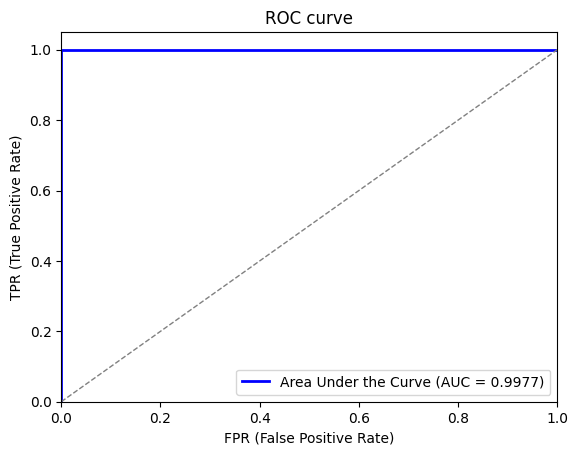

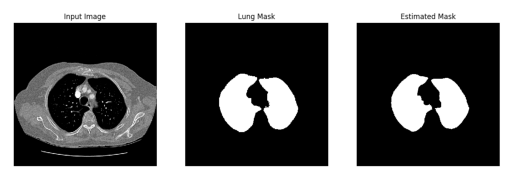

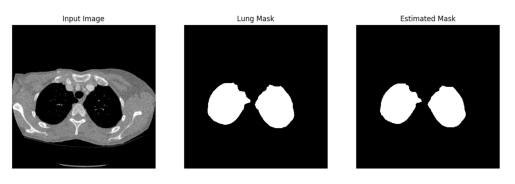

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#from models import BCDU_net_D3  # Removed this line - No need to import from models
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import jaccard_similarity_score  # Commented out since it may cause issues
from sklearn.metrics import jaccard_score # This line was added to import jaccard_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion
from tensorflow import keras # Import keras
!pip install scikit-image # installing scikit-image for resize
from skimage.transform import resize # import resize for preprocessing


# Assuming BCDU_net_D3 is defined in a previous cell or in the same notebook
# If it's in a separate file in the same directory, you can import it like this:
# from your_file_name import BCDU_net_D3
# But based on your code structure, it seems like it's defined earlier in the notebook

####################################  Load Data #####################################
folder    = './processed_data/'
te_data   = np.load(folder+'data_test.npy')
FOV       = np.load(folder+'FOV_te.npy')
te_mask   = np.load(folder+'mask_test.npy')

# te_data  = np.expand_dims(te_data, axis=3) # This line is creating an issue

print('Dataset loaded')
#te_data2  = dataset_normalized(te_data)
te_data2 = te_data /255.

#Reshape to the model's expected input shape
te_data2 = resize(te_data2, (te_data2.shape[0], 256, 256, 1)) # Added to resize to 256x256

# Load the saved model directly using keras.models.load_model
#model = keras.models.load_model('weight_lung.keras') # Load the saved model
model = keras.models.load_model('weight_lung.keras') # Load the saved model with .keras extension

# The rest of the code for predictions and evaluation remains the same...
predictions = model.predict(te_data2, batch_size=2, verbose=1)


# This line was moved from ipython-input-3-5a093508ddee cell
# ipython-input-1-a13349d63bed.py
import numpy as np # Import numpy and assign it to the alias 'np'

# Post-processing
predictions = np.squeeze(predictions)
predictions = np.where(predictions>0.5, 1, 0)

# Resize predictions to match FOV shape
predictions_resized = resize(predictions, (predictions.shape[0], FOV.shape[1], FOV.shape[2]))

Estimated_lung = np.where((FOV - predictions_resized)>0.5, 1, 0)

# Performance checking

y_scores = Estimated_lung.reshape(Estimated_lung.shape[0]*Estimated_lung.shape[1]*Estimated_lung.shape[2], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2], 1)

y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

# ... (rest of the code from ipython-input-3-5a093508ddee)







import os # Importing the os module
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, jaccard_score, f1_score # Importing the modules

output_folder = 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#Jaccard similarity index
# jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True) #Replaced in next line
jaccard_index = jaccard_score(y_true, y_pred, average='binary') # For newer versions of sklearn

print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(output_folder+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# Sample results
fig,ax = plt.subplots(5, 3, figsize=[15,15])
all_ind = [1, 100, 200, 253, 193] # random samples
all_ind = np.array(all_ind)
for idx in range(5):
    ax[idx, 0].imshow(np.uint8(np.squeeze(te_data[all_ind[idx]])))
    ax[idx, 1].imshow(np.squeeze(te_mask[all_ind[idx]]), cmap='gray')
    ax[idx, 2].imshow(np.squeeze(Estimated_lung[all_ind[idx]]), cmap='gray')

plt.savefig('sample_results.png')